# Linear Systems and Signal Convolution
## Introduction


Digital Filter is a model of a physical system

In [213]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
f_rate, signal = wavfile.read('record3.wav')

time = np.linspace(
    0, # start
    len(signal) / f_rate,
    num = len(signal)
)
signal = [s[0] for s in signal]
norm = np.max(np.abs(signal))
signal = signal/norm
plt.figure(figsize=(18, 9))
plt.plot(time, signal)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'record3.wav'

In [215]:
from IPython.display import Audio
Audio(signal/norm, rate=f_rate)

NameError: name 'signal' is not defined

## Task 1

In [214]:
import time
from collections import defaultdict
audios = ['DSP_2020_A3_DATA/drums.wav',
         #'DSP_2020_A3_DATA/music_20s_8000.wav',
#          'DSP_2020_A3_DATA/speech.wav',
#          'DSP_2020_A3_DATA/violin.wav',
          'DSP_2020_A3_DATA/voice.wav'
]
# slowest with for loops
def loops(signal, kernal):
    flen =  len(signal) - len(kernal) + 1
    trans_signal = [(signal[i:i+len(kernal)]*kernal[::-1]).sum() for i in range(flen)]
    return trans_signal

def striding(signal, kernal):
    trans_signal = []
    signals = np.lib.stride_tricks.sliding_window_view(signal, len(kernal))
    for s in signals:
        trans_signal.append(np.dot(s, np.flip(kernal)))
    return trans_signal
        
def using_fft(signal, kernal):
    fflen =  len(signal) - len(kernal) + 1
    flen =  len(signal)
    ss = np.fft.fft(signal)
    flen -= int((len(signal) - len(kernal))/2) + len(kernal)
    kk =  np.zeros(int((len(signal) - len(kernal))/2))
    kk = np.append(kk, kernal)
    kk = np.append(kk, np.zeros(flen))
    kk = np.fft.fft(kk)
    new_signal = np.fft.ifft(kk * ss)
    new_signal = np.real(new_signal)
    return np.fft.fftshift(new_signal)[:fflen]
    
methods = [loops, striding, using_fft]
times = defaultdict(list)
for method in methods:
    for audio in audios:
        start = time.time()
        fs, ex_signal = wavfile.read(audio)
        try:
          ex_signal = [s[0] for s in ex_signal]
        except:
            pass
        trans_signal = method(ex_signal, signal)
        times[method.__name__].append(time.time()-start)

    

<ipython-input-214-3ad460cc074f>:40: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, ex_signal = wavfile.read(audio)


NameError: name 'signal' is not defined

In [125]:
for t in times:
    print(t)
    plt.figure(figsize=(18, 9))
    plt.plot(times[t])
    plt.show()

NameError: name 'times' is not defined

In [26]:
# here we can listen
path_to_audio = 'DSP_2020_A3_DATA/voice.wav'
method = striding
fs, ex_signal = wavfile.read(path_to_audio)
try:
    ex_signal = [s[0] for s in ex_signal]
except:
    pass
trans_signal = method(ex_signal, signal)
print(trans_signal[:10])
Audio(trans_signal, rate=fs)

<ipython-input-26-f98abe1b59ed>:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, ex_signal = wavfile.read(path_to_audio)


[594.4080946680178, 729.5563127359801, 658.1594529883057, 399.4033981029561, 132.36030021180628, -124.93070264296954, -405.10134450686076, -557.7797218896766, -504.86780550695335, -378.394833778433]


In [4]:
# тесты 
s = np.array([0,0,0,1,1,1,0,0,0])
k = np.array([2,2])

In [5]:
loops(s, k)

[0, 0, 2, 4, 4, 2, 0, 0]

In [6]:
np.real(striding(s, k))

array([0, 0, 2, 4, 4, 2, 0, 0])

## Task 2: Frequency Filtering with IIR Filters

TODO:
- [ ] work on adding comments/description to the cells
- [ ] add labels to graphs
- [x] think about graphs relocation for better visualizations
- [x] verify filter's correctness through DFT
- [ ] check for another performance improvements

### Some Theory
References:
1. https://en.wikipedia.org/wiki/Infinite_impulse_response
2. https://dspguru.com/dsp/faqs/iir/basics/
3. https://www.advsolned.com/difference-between-iir-and-fir-filters-a-practical-design-guide/
4. https://www.youtube.com/watch?v=jL_1DwUMD2w&ab_channel=PhysicsVideosbyEugeneKhutoryansky
5. https://www.youtube.com/watch?v=9yNQBWKRSs4&ab_channel=BarryVanVeen
---

In this section we are going to dicuss *Infinite Impulse Response*(IIR) filters. 

> Essentially IIR filters are one of the two digital filters which is needed to filter out some frequencies from the signal.

**Why IIR is infinite and FIR is not?** \
Because, IIR has a **feedback term**. In IIR each output uses previous outputs and weighted input signal.\
By that if the input signal in infinite the output signal will be nonzero too.
While, in FIR filters if filters has N coefficients the output will become zero after N terms, because there are no feedback term.

**What are the advantages of IIR over FIR?** \
IIR uses **less memory** and calculations to reach same result as FIR

**What are the disadvantages of IIR compared to FIR?** \
Single floating point arithmetics can induce **noise** that will be amplified each iteration

Now let us observe the canonical representation of the IIR filter\
$$
%     y_0 = (b \cdot x_0) + (a_1 \cdot y_1) + (a_2 \cdot y_2)
y(n) = \sum_{k=0}^{q} b_k x (n - k) - \sum_{k=1}^{p} a_k y (n - k)
$$

where:
- $y(n)$ is a nth output signal value
- $x(n)$ is a nth input signal value
- $b_k$ is the kth term of feedforward coefficients
- $a_k$ is the kth term of feedback coefficients
<!-- - $y_0$ is a current signal response
- $y_1, y_2$ are two output samples
- $a_1, a_2$ are
- $x_0$ is an input
- $b$ is a -->

### Implement IIR filter

To implement IIR we will need to have one memory buffer and two sets of coefficients.\
Memory buffer will store all the calculated values of output signal\
At each step we will refer to memory buffer and retrieve last values\
and use them to calculate next value

In [212]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile

from numba import jit

In [221]:
def IIR_filter(a, b: np.array):
    '''
    Returns a filter with given coefficients
    
    :param a - np.array with coefficients
    :param b - np.array with coefficients
    
    :returns function
    '''
    p = len(a)
    q = len(b)
    
    # we will need reversed coefficients
    # and numba works better with contiguous arrays
    a_reverse = np.ascontiguousarray(a[::-1])
    b_reverse = np.ascontiguousarray(b[::-1])
    
    # use numba's decorator to speed up calculations(on average about 2s improvement)
    @jit
    def func(signal: np.array) -> np.array:
        '''
        Returns filtered signal
        
        :param signal - np.array values of the signal
        
        :returns filtered signal
        '''
        # prepend zeroes to the signal
        shift = max(p, q)
        zeros = np.zeros(shift)
        signal = np.concatenate((signal, zeros))  # np.insert(signal, 0, zeros, axis=0)
        
        # append zero terms to the output
        output = zeros.copy()

        for n, xn in enumerate(signal):
            # ignore zero terms
            if n < shift:
                continue
            # @ symbol in numpy refers to dot/matrix product
            feedforward = b_reverse @ signal[n - q: n]
            feedback = a_reverse @ output[n - p: n]
            
            yn = feedforward + feedback
            yn = np.array([yn])
            
            output = np.append(output, yn, axis=0)
        return output[3:]  # remove previously appended zero terms
    
    return func

### Create and Apply filters

In [222]:
audio = 'DSP_2020_A3_DATA/music_20s_8000.wav'
fs, ex_signal = wavfile.read(audio)

Let us take sample audio file

Audio includes sound of different musical instruments

Audio can be listened in the next cell\
The Spectogram is also provided

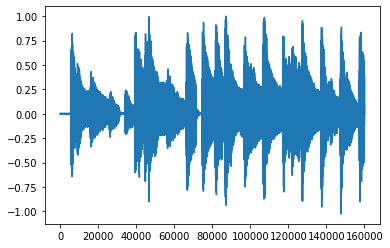

In [121]:
plt.plot(ex_signal)
plt.show()

Audio(ex_signal,rate=fs)

#### Lowpass Filter

In this section we will create and apply lowpass filter

Lowpass filter removes high frequencies from the signal and keeps low\
Changing coefficients will change threshold of the filter

In [223]:
# Lowpass, starts cutting frequencies after 20Hz
# Better to listen in your headphones
a = [1.9733442497812987,
     -0.9736948719763]# coefficients for a_1 and a_2
b = [0.00008765554875401547,
     0.00017531109750803094,
     0.00008765554875401547] # coefficients for b_0, b_1 and b_2

# create lowpass filter with given coefficients
lowpass_filter = IIR_filter(np.array(a), np.array(b))

We will apply lowpass filter

In [224]:
%%time
filtered_signal_low = lowpass_filter(ex_signal)

CPU times: user 7.48 s, sys: 65.9 ms, total: 7.55 s
Wall time: 7.65 s


Visually we can see waves with higher frequency disappeared from the graph\
and only low frequency left

We can hear only drums/bass sounds properly\
Difficult to recognize piano in the background

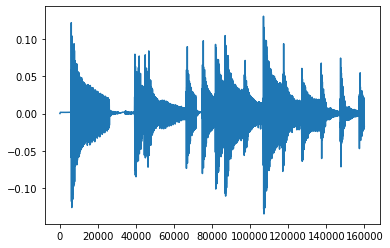

In [70]:
plt.plot(filtered_signal)
plt.show()

Audio(filtered_signal,rate=fs)

#### Highpass Filter

In this section we are going to apply highpass filter\

Highpass filter removes low frequencies from the signal and keeps high\
Changing coefficients will change threshold of the filter

In [225]:
# Highpass, starts passing frequencies after 3kHz
a = [-0.3769782747249014,
     -0.19680764477614976] # coefficients for a_1 and a_2
b = [0.40495734254626874,
     -0.8099146850925375,
     0.4049573425462687] # coefficients for b_0, b_1 and b_2

# create highpass filter wih given coefficients
highpass_filter = IIR_filter(a, b)

We will apply highpass filter on our signal

Visally, in the spectogram only frequent ticks left\
We cannot hear bass sounds clearly

In [226]:
%%time
filtered_signal_high = highpass_filter(ex_signal)

CPU times: user 8.05 s, sys: 61.2 ms, total: 8.11 s
Wall time: 8.24 s


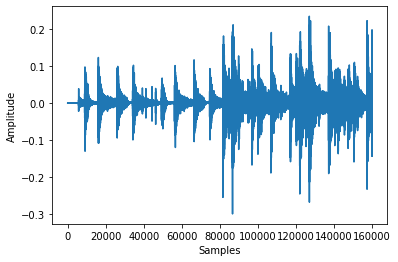

In [227]:
plt.plot(filtered_signal)
plt.ylabel("Amplitude")
plt.xlabel("Samples")
plt.show()

Audio(filtered_signal,rate=fs)

### Verify results

In this section we are going to actually verify that the filters did work

For that we are going to compute the approximate DFT spectrum of these IIR filters

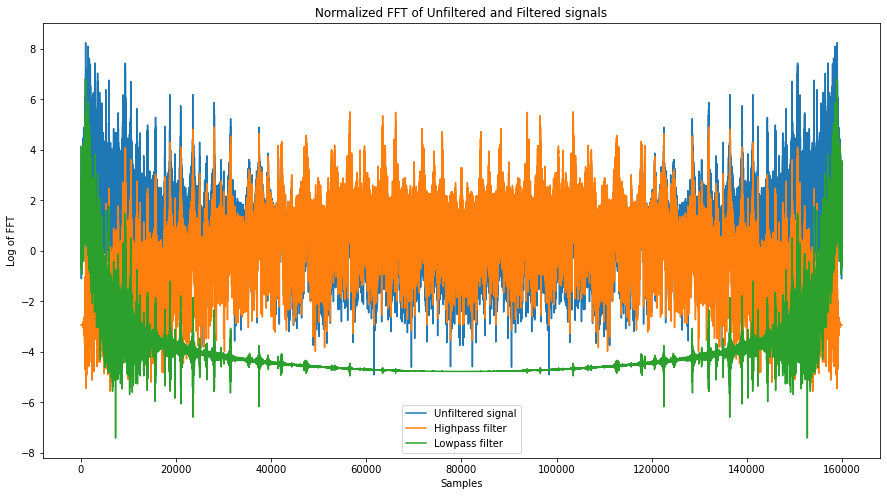

In [232]:
# N = 1e8
plt.figure(figsize=(15, 8))
plt.plot(np.log(np.abs(np.fft.fft(ex_signal))), label="Unfiltered signal")
plt.plot(np.log(np.abs(np.fft.fft(filtered_signal_high))), label="Highpass filter")
plt.plot(np.log(np.abs(np.fft.fft(filtered_signal_low))), label="Lowpass filter")

plt.title("Normalized FFT of Unfiltered and Filtered signals")
plt.ylabel("Log of FFT")
plt.xlabel("Samples")

plt.legend()

plt.show()

#### DFT of Lowpass Filter Result

Left graph shows overall FFT result, center graph shows FFT in range \[0kHz, 2kHz\] and right graph shows FFT in range \[2kHz, 80kHz\]\
As you can see low pass filter removed all frequencies after **2kHz**

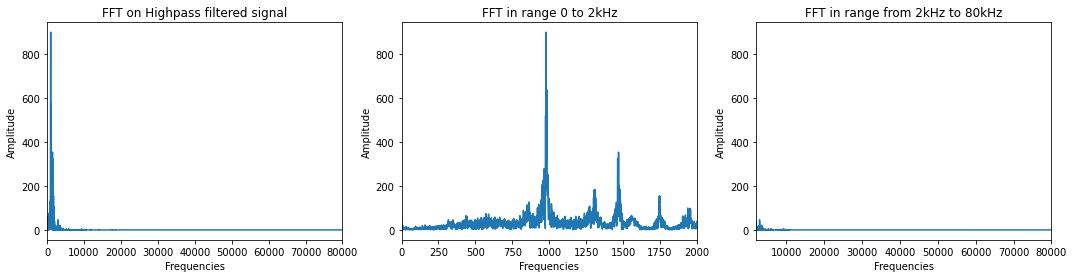

In [242]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

ax1.plot(np.abs(np.fft.fft(filtered_signal_low)))
ax2.plot(np.abs(np.fft.fft(filtered_signal_low)))
ax3.plot(np.abs(np.fft.fft(filtered_signal_low)))

ax1.set_xlim([0, 80000])
ax2.set_xlim([0, 2000])
ax3.set_xlim([2000, 80000])

ax1.set_title("FFT on Highpass filtered signal")
ax2.set_title("FFT in range 0 to 2kHz")
ax3.set_title("FFT in range from 2kHz to 80kHz")

ax1.set_ylabel("Amplitude")
ax2.set_ylabel("Amplitude")
ax3.set_ylabel("Amplitude")

ax1.set_xlabel("Frequencies")
ax2.set_xlabel("Frequencies")
ax3.set_xlabel("Frequencies")

plt.show()

#### DFT of Highpass Filter Result

Left graph shows overall FFT result, center graph shows FFT in range \[0kHz, 3kHz\] and right graph shows FFT in range \[3kHz, 80kHz\]\
As you can see high pass filter removed all frequencies before **3kHz**

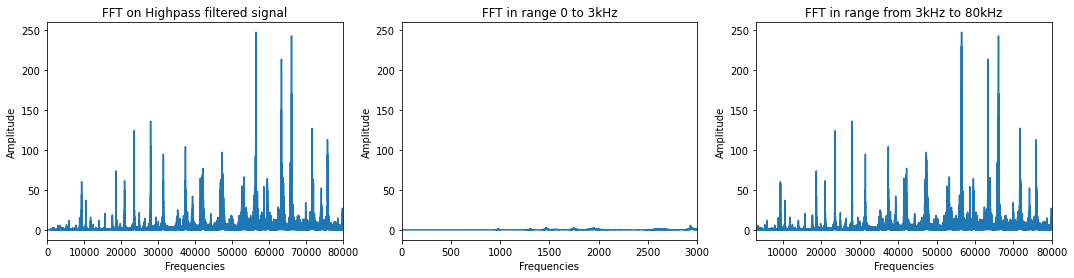

In [241]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

ax1.plot(np.abs(np.fft.fft(filtered_signal_high)))
ax2.plot(np.abs(np.fft.fft(filtered_signal_high)))
ax3.plot(np.abs(np.fft.fft(filtered_signal_high)))

ax1.set_xlim([0, 80000])
ax2.set_xlim([0, 3000])
ax3.set_xlim([3000, 80000])

ax1.set_title("FFT on Highpass filtered signal")
ax2.set_title("FFT in range 0 to 3kHz")
ax3.set_title("FFT in range from 3kHz to 80kHz")

ax1.set_ylabel("Amplitude")
ax2.set_ylabel("Amplitude")
ax3.set_ylabel("Amplitude")

ax1.set_xlabel("Frequencies")
ax2.set_xlabel("Frequencies")
ax3.set_xlabel("Frequencies")

plt.show()